# Generating DESI images, spectra, and conditional models

Here we will work on generative models for different data modalities. In particular, we'll work with images and spectra. Let's first start by training an unconditional image generator on DESI imaging data. The dataset and dataloaders have been adapted from [AstroClip](https://github.com/PolymathicAI/AstroCLIP)

Let's look at the dataset first.

In [ ]:
# run the installs if running for the first time
# !pip install lightning wandb

In [1]:
import matplotlib.pyplot as plt
from datasets import load_dataset

dataset = load_dataset(
    '/ocean/projects/phy230064p/shared/desi_data/legacy_survey.py',
    cache_dir='/ocean/projects/phy230064p/shared/desi_data',
)
dataset.set_format(type='torch', columns=['image', 'spectrum',])# 'redshift'])

/jet/home/cuestala/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/jet/home/cuestala/.local/lib/python3.10/site-packages/datasets/load.py:922: FutureWarning: The repository for legacy_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /ocean/projects/phy230064p/shared/desi_data/legacy_survey.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [2]:
import sys
sys.path.insert(1, '../data')
sys.path.insert(1, '../models')

from data_utils import ToRGB
from torchvision.transforms import Compose, RandomVerticalFlip, RandomHorizontalFlip, RandomRotation, CenterCrop, InterpolationMode

image_transforms = Compose([
        ToRGB(),
        RandomRotation(45,interpolation=InterpolationMode.BILINEAR),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        CenterCrop(96),
])

/tmp/ipykernel_45806/4223395279.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3604.)
  plt.imshow(image_transforms(dataset['train'][i]['image'].reshape([1,152,152,3])).squeeze().T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


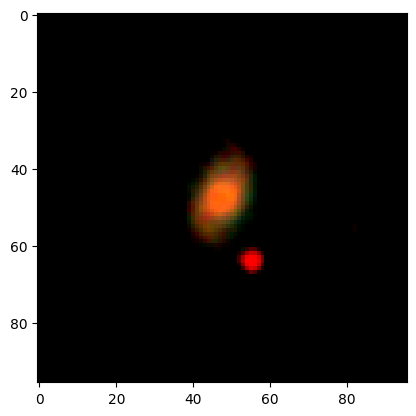

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


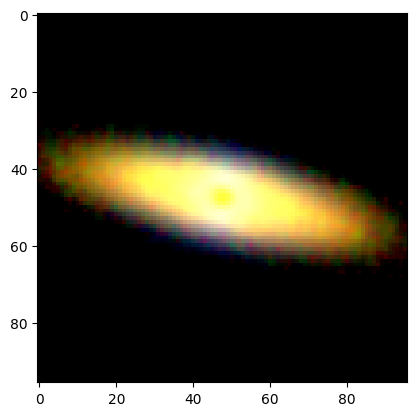

In [3]:
# and let's look at a couple of images after transforming them 

for i in range(2):
    plt.imshow(image_transforms(dataset['train'][i]['image'].reshape([1,152,152,3])).squeeze().T)
    plt.show()

In [4]:
# and let's make the pytorch dataloaders for training and validating the model
from torch.utils.data import DataLoader
from multiprocessing import cpu_count

print(f'using {cpu_count()} cpus to load data')

batch_size = 32
train_loader = DataLoader(
    dataset['train'], 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=cpu_count(), 
    pin_memory=True, 
    drop_last=True,
)

val_loader = DataLoader(
    dataset['test'], 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=cpu_count(), 
    pin_memory=True, 
    drop_last=True,
)

using 40 cpus to load data


Now we are going to add some bells and whistles to the previous diffusion model implementation. In particular, we will implement a [Variational Diffusion model](https://arxiv.org/abs/2107.00630), compared to the DDPM model we implemented in the tutorials, this one will
- work on continuous time, instead of discrete time steps
- use a noise scheduler that has some learnable parameters, instead of them being fixed to arbitrary values
- add a weighting to the denoising loss function that will allow us to compute the ELBO, or bound to the likelihood, that we may use to detect anomalies.
- the denoising model will now be a CNN model suitable for images, [U-Net ](https://en.wikipedia.org/wiki/U-Net)
- the denoising model takes both a noisy x, and the diffusion time, t. There are several ways in which one could condition the CNN on diffusion time. Here, t will be converted into sinusoidal embeddings like the ones used by transformers. Then those embeddings will be added to the image in the ResNet blocks of the UNet. If these words don't mean anything to you, for now just keep in mind that the CNN is also conditioned on diffusion time.

In [5]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Callable
from tqdm import trange

from torch.special import expm1

import lightning as L

from torch.distributions.normal import Normal
from torch import autograd, Tensor

from unet import Unet

We'll work with linear noise schedules, but with some learnable min and max parameters

In [6]:
class FixedLinearSchedule(torch.nn.Module):
    def __init__(self, gamma_min, gamma_max):
        super().__init__()
        self.gamma_min = gamma_min
        self.gamma_max = gamma_max

    def forward(self, t):
        return self.gamma_min + (self.gamma_max - self.gamma_min) * t


class LearnedLinearSchedule(torch.nn.Module):
    def __init__(self, gamma_min, gamma_max):
        super().__init__()
        self.b = torch.nn.Parameter(torch.tensor(gamma_min))
        self.w = torch.nn.Parameter(torch.tensor(gamma_max - gamma_min))

    def forward(self, t):
        # abs needed to make it monotonic
        return self.b + self.w.abs() * t

In [7]:
# we will use the Kl divergence between a Gaussian and a standard Gaussian later on the diffusion model
def kl_std_normal(mean_squared, var):
    return 0.5 * (var + mean_squared - torch.log(var.clamp(min=1e-15)) - 1.0)


class GaussianDiffusion(nn.Module):
    def __init__(
        self, 
        denoising_model: Callable, 
        antithetic_time_sampling: bool = True,
        beta_schedule = 'learned_linear',
        beta_schedule_fn_kwargs = {'gamma_min': -13., 'gamma_max': 5.},
        data_noise: float = 1.e-3,

    ):
        """ Variational diffusion model

        Args:
            denoising_model (Callable): denoising model 
            antithetic_time_sampling (bool, optional): whether to apply antithetic time sampling. Defaults to True.
            beta_schedule (str, optional): whether to use a linear or a learned linear noise schedule. Defaults to 'learned_linear'.
            beta_schedule_fn_kwargs (dict, optional): kwargs of the noise scheduler. Defaults to {'gamma_min': -13., 'gamma_max': 5.}.
            data_noise (float, optional): we will assume the model aims at reproducing the data up to this noise level. Defaults to 1.e-3.

        """
        super().__init__()
        self.denoising_model = denoising_model
        self.antithetic_time_sampling = antithetic_time_sampling
        if beta_schedule == 'linear':
            self.gamma = FixedLinearSchedule(**beta_schedule_fn_kwargs)
        elif beta_schedule == 'learned_linear':
            self.gamma = LearnedLinearSchedule(**beta_schedule_fn_kwargs)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.data_noise = data_noise

    def to(self, device: str):
        """
        Send model to device
        """
        # Override the to method to handle device transfer
        self = super().to(device)
        return self
        
    def get_xt(self, x0: torch.Tensor, t: torch.Tensor, epsilon:torch.Tensor=None)->torch.Tensor:
        """ Get a noisy version of x0 at time t, and given some noise psilon

        Args:
            x0 (torch.Tensor): starting point x0 
            t (torch.Tensor): time t 
            epsilon (torch.Tensor, optional): noise. Defaults to None.

        Returns:
            torch.Tensor: noisy x 
        """
        with torch.enable_grad():  # Need gradient to compute loss even when evaluating
            #t = t.view(t.shape[0], 1, 1, 1)
            t = t.view(t.shape[0], *([1] * (x0.dim() - 1)))
            gamma_t = self.gamma(t)
        alpha = torch.sqrt(torch.sigmoid(-gamma_t))
        scale = torch.sqrt(torch.sigmoid(gamma_t))
        if epsilon is None:
            epsilon = torch.randn_like(x0)
        return alpha * x0 + epsilon* scale, gamma_t

    def sample_times(
        self,
        batch_size: int,
        device: str,
    ) -> torch.Tensor:
        """Sample diffusion times for batch, used for monte carlo estimates

        Args:
            batch_size (int): size of batch

        Returns:
            Tensor: times
        """
        if self.antithetic_time_sampling:
            t0 = np.random.uniform(0, 1 / batch_size)
            times = torch.arange(t0, 1.0, 1.0 / batch_size, device=device)
        else:
            times = torch.rand(batch_size, device=device)
        return times

    def get_diffusion_loss(
        self,
        gamma_t: torch.Tensor,
        times: torch.Tensor,
        pred_noise: torch.Tensor,
        noise: torch.Tensor,
        bpd_factor: float,
    ) -> float:
        """get loss for diffusion process. Eq. 17 in arxiv:2107.00630

        Args:
            gamma_t (Tensor): gamma at time t
            times (Tensor): time steps
            pred_noise (Tensor): noise prediction
            noise (Tensor): noise added

        Returns:
            float: diffusion loss
        """
        gamma_grad = autograd.grad(  # gamma_grad shape: (B, )
            gamma_t,  # (B, )
            times,  # (B, )
            grad_outputs=torch.ones_like(gamma_t),
            create_graph=True,
            retain_graph=True,
        )[0]
        pred_loss = (
            ((pred_noise - noise) ** 2).flatten(start_dim=1).sum(axis=-1)
        )  # (B, )
        return bpd_factor * 0.5 * pred_loss * gamma_grad

    def get_latent_loss(
        self,
        x: torch.Tensor,
        bpd_factor: float,
    ) -> float:
        """Latent loss to ensure the prior is truly Gaussian

        Args:
            x (Tensor): data sample

        Returns:
            float: latent loss
        """
        gamma_1 = self.gamma(torch.tensor([1.0], device=x.device))
        sigma_1_sq = torch.sigmoid(gamma_1)
        mean_sq = (1 - sigma_1_sq) * x**2
        return bpd_factor * kl_std_normal(mean_sq, sigma_1_sq).flatten(start_dim=1).sum(
            axis=-1
        )

    def get_reconstruction_loss(
        self,
        x: torch.Tensor,
        bpd_factor: float,
    ):
        """Measure reconstruction error

        Args:
            x (Tensor): data sample

        Returns:
            float: reconstruction loss
        """
        noise_0 = torch.randn_like(x)
        times = torch.tensor([0.0], device=x.device)
        z_0, gamma_0 = self.get_xt(
            x0=x,
            t=times,
            epsilon=noise_0,
        )
        # Generate a sample for z_0 -> closest to the data
        alpha_0 = torch.sqrt(torch.sigmoid(-gamma_0))
        z_0_rescaled = z_0 / alpha_0
        return -bpd_factor * Normal(loc=z_0_rescaled, scale=self.data_noise).log_prob(
            x
        ).flatten(start_dim=1).sum(axis=-1)

    def compute_loss(
        self,
        x: torch.Tensor,
        noise: Optional[torch.Tensor] = None,
    ) -> float:
        """Get loss for diffusion model. Eq. 11 in arxiv:2107.00630

        Args:
            x (Tensor): data sample
            noise (Optional[Tensor], optional): noise. Defaults to None.

        Returns:
            float: loss
        """
        bpd_factor = 1 / (np.prod(x.shape[1:]) * np.log(2))
        # Sample from q(x_t | x_0) with random t.
        times = self.sample_times(
            x.shape[0],
            device=x.device,
        ).requires_grad_(True)
        if noise is None:
            noise = torch.randn_like(x)
        x_t, gamma_t = self.get_xt(x0=x, t=times, epsilon=noise)
        # Predict noise added
        pred_noise = self.denoising_model(
            x_t,
            gamma_t.squeeze(),
        )

        # *** Diffusion loss
        diffusion_loss = self.get_diffusion_loss(
            gamma_t=gamma_t,
            times=times,
            pred_noise=pred_noise,
            noise=noise,
            bpd_factor=bpd_factor,
        )

        # *** Latent loss: KL divergence from N(0, 1) to q(z_1 | x)
        latent_loss = self.get_latent_loss(
            x=x,
            bpd_factor=bpd_factor,
        )

        # *** Reconstruction loss:  - E_{q(z_0 | x)} [log p(x | z_0)].
        recons_loss = self.get_reconstruction_loss(
            x=x,
            bpd_factor=bpd_factor,
        )

        # *** Overall loss, Shape (B, ).
        loss = diffusion_loss + latent_loss + recons_loss
        return loss.mean()

    def alpha(self, gamma_t: torch.Tensor) -> torch.Tensor:
        """Eq. 4 arxiv:2107.00630

        Args:
            gamma_t (Tensor): gamma evaluated at t

        Returns:
            Tensor: alpha
        """
        return torch.sqrt(torch.sigmoid(-gamma_t))

    def sigma(self, gamma_t):
        """Eq. 3 arxiv:2107.00630

        Args:
            gamma_t (Tensor): gamma evaluated at t

        Returns:
            Tensor: sigma
        """
        return torch.sqrt(torch.sigmoid(gamma_t))

    def sample_zs_given_zt(
        self,
        zt: torch.Tensor,
        t: torch.Tensor,
        s: torch.Tensor,
    ) -> torch.Tensor:
        """Sample p(z_s|z_t, x) used for standard ancestral sampling. Eq. 34 in arxiv:2107.00630

        Args:
            z (Tensor): latent variable at time t
            t (Tensor): time t
            s (Tensor): time s

        Returns:
            zs, samples for time s
        """
        batch_size = len(zt)
        t = torch.full((batch_size,), t, device=zt.device)
        t = t.view(batch_size, *([1] * (zt.dim() - 1)))
        gamma_t = self.gamma(t)
        gamma_s = self.gamma(s)
        c = -expm1(gamma_s - gamma_t)
        alpha_t = self.alpha(gamma_t)
        alpha_s = self.alpha(gamma_s)
        sigma_t = self.sigma(gamma_t)
        sigma_s = self.sigma(gamma_s)
        pred_noise = self.denoising_model(
            zt,
            gamma_t.squeeze(),
        )
        mean = alpha_s / alpha_t * (zt - c * sigma_t * pred_noise)
        scale = sigma_s * torch.sqrt(c)
        return mean + scale * torch.randn_like(zt)

    @torch.no_grad()
    def sample(
        self,
        z: Optional[torch.Tensor] = None,
        n_sampling_steps: int=250,
        device: str = "cpu",
        batch_size=None,
        image_shape = None,
    ) -> Tensor:
        """Generate new samples 

        Args:
            batch_size (int): number of samples in batch
            n_sampling_steps (int): number of sampling steps
            device (str, optional): device to run model. Defaults to "cpu".
            z (Optional[Tensor], optional): initial latent variable. Defaults to None.

        Returns:
            Tensor: generated sample
        """
        if z is None:
            z = torch.randn(
                (batch_size, *image_shape),
                device=device,
            )
        steps = torch.linspace(
            1.0,
            0.0,
            n_sampling_steps + 1,
            device=device,
        )
        for i in range(n_sampling_steps):
            z = self.sample_zs_given_zt(
                zt=z,
                t=steps[i],
                s=steps[i + 1],
            )
        return z


Now we will use [pytorch lightning](https://lightning.ai/) to facilitate training the model. PyTorch Lightning is a lightweight wrapper around PyTorch, designed to work more efficiently with PyTorch by abstracting away much of the boilerplate code to train and deploy a model. 

Let's first define a lightning module with the diffusion model. The main functions of a lightning module is train_step, that defines what happens inside each training step given a batch of data. The training loop is handled by lightning so that we don't have to worry about it.

In [8]:
class VariationalDiffusion(L.LightningModule):
    def __init__(
        self,
        denoising_model,
        image_transform=None,
        n_sampling_steps=250,
        beta_schedule='learned_linear',
        beta_schedule_fn_kwargs = {'gamma_min': -13., 'gamma_max': 5.},
        learning_rate = 1.e-4,
    ):
        super().__init__()

        self.save_hyperparameters('learning_rate', 'beta_schedule', 'n_sampling_steps')
        self.image_transform = image_transform
        self.diffusion = GaussianDiffusion(
            denoising_model = denoising_model,
            beta_schedule = beta_schedule,
            beta_schedule_fn_kwargs = beta_schedule_fn_kwargs,
        )

    def setup(self, stage):
        if stage == 'fit':
            self.diffusion = self.diffusion.to(self.device)

    @torch.no_grad()
    def on_after_batch_transfer(self, batch, dataloader_idx):
        im, sp = batch['image'], batch['spectrum']

        im = self.image_transform(im) if self.image_transform is not None else im
        #sp = self.spectrum_transform(sp) if self.spectrum_transform is not None else sp

        return {'image': im, 'spectrum': sp}

    def training_step(self, batch, batch_idx):
        image = batch['image']
        loss = self.diffusion.compute_loss(image)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # we are going to generate some example images while training the model to check that it is generating
        # sensible things
        image = batch['image']
        if batch_idx == 0:
            wandb_logger = self.logger.experiment
            epsilon = torch.randn(image.shape, device = image.device)
            sampled_images = self.diffusion.sample(epsilon, n_sampling_steps=self.hparams.n_sampling_steps).cpu().detach().numpy()
            fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
            for i in range(5):
                # select a random true image index
                true_image_idx = torch.randint(0, image.shape[0], (1,)).item()
                ax[0,i].imshow(image[true_image_idx].cpu().detach().numpy().T)
                ax[1,i].imshow(sampled_images[i].T)
            wandb_logger.log({"images": plt})
            plt.close()
        loss = self.diffusion.compute_loss(image)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self,):
        optimizer = torch.optim.Adam(self.diffusion.parameters(), lr=self.hparams.learning_rate, betas = (0.9,0.99))
        return optimizer

Now we need to define a denoising model appropriate for images, we'll use a Unet. The implementation is quite complex, for now we will just use it as a model that takes in an image and returns an image of the same dimensionality.

In [9]:
denoising_model = Unet(
    dim = 96,
    dim_mults = (1, 2, 4, 8),
    flash_attn = False, 
)

n_time_steps = 250 

vdm = VariationalDiffusion(denoising_model=denoising_model,image_transform=image_transforms, beta_schedule='learned_linear', n_sampling_steps=n_time_steps)

Let's look at how the forward diffusion process looks like now

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


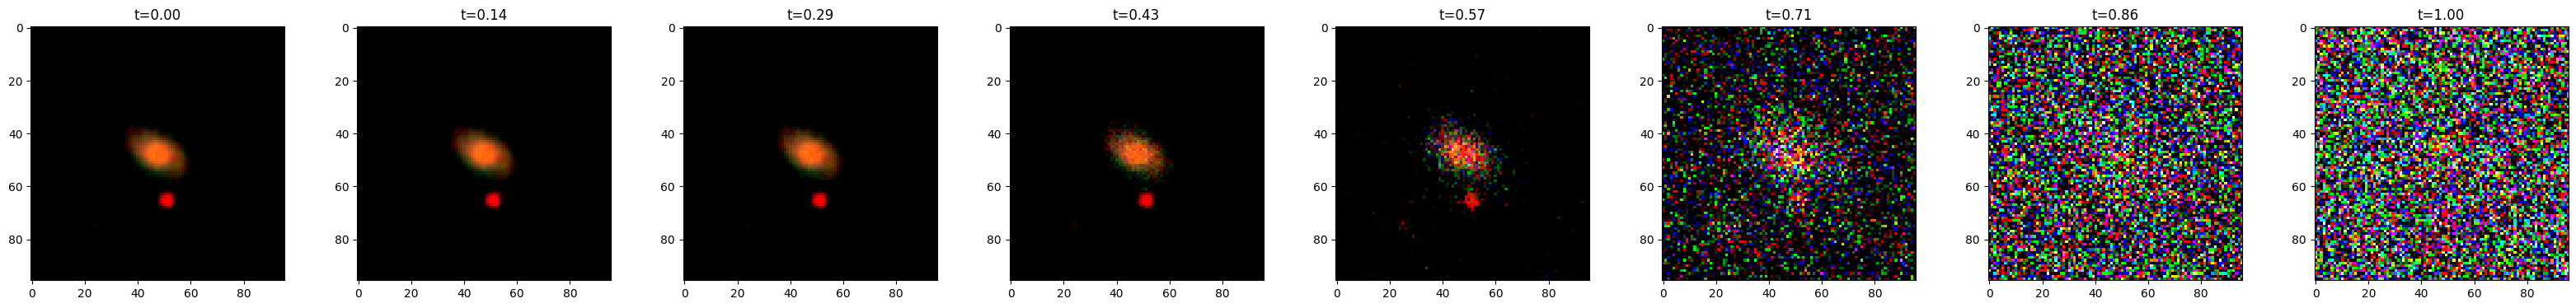

In [10]:

plot_steps = torch.Tensor(np.linspace(0.,1., 8), )
fig, ax = plt.subplots(1,len(plot_steps), figsize=(5 * len(plot_steps),4))
image = image_transforms(dataset['train'][0]['image'].reshape([1,152,152,3])).detach().cpu()
for i, t in enumerate(plot_steps):
    noisy_image, _ = vdm.diffusion.get_xt(image, torch.tensor([t]))
    ax[i].imshow(noisy_image.cpu().detach().squeeze().T)
    ax[i].set_title(f"t={t:.2f}")

finally, we will use the online weights and biases framework to keep track of our experiments

In [11]:
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="IAIFI_HACK", log_model="all")


In [12]:
#If running for the first time, log in with your weights and biases key (create one if you don't have any)

#wandb.login(key=your_key)

Let's train the model!

In [13]:

trainer = L.Trainer(
    max_steps = 300_000, gradient_clip_val=0.5, logger=wandb_logger, log_every_n_steps=10, val_check_interval=1_000
)
trainer.fit(model=vdm, train_dataloaders=train_loader, val_dataloaders = val_loader)


Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: floppy. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in ./wandb/run-20240121_204914-c458obvm
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run leafy-galaxy-41
wandb: ⭐️ View project at https://wandb.ai/floppy/IAIFI_HACK
wandb: 🚀 View run at https://wandb.ai/floppy/IAIFI_HACK/runs/c458obvm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type              | Params
------------------------------------------------
0 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch 0:   2%|▏         | 96/4949 [00:51<43:04,  1.88it/s, v_num=obvm, train_loss=-1.58]  

/jet/home/cuestala/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


how could you use this model to find anomalous images? 


Let's now adapt this model to generate spectra. Again, let's start by looking at the data

torch.Size([7781, 1])
tensor(-5.4479) tensor(11.9854)


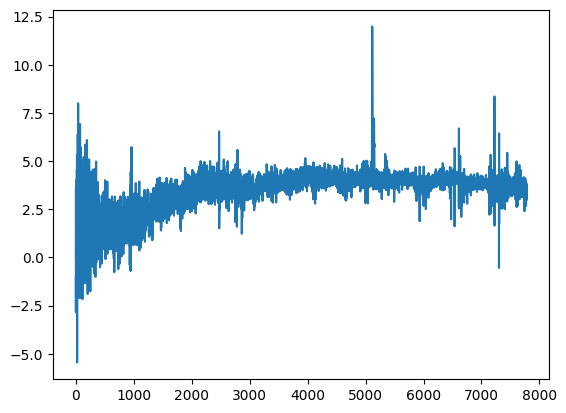

torch.Size([7781, 1])
tensor(-18.6970) tensor(49.3910)


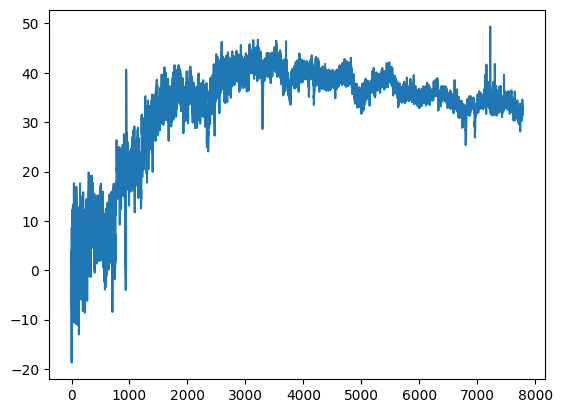

In [14]:
for i in range(2):
    print(dataset['train'][i]['spectrum'].shape)
    print(dataset['train'][i]['spectrum'].min(), dataset['train'][i]['spectrum'].max())
    plt.plot(dataset['train'][i]['spectrum'][:])
    plt.show()

In [15]:
# you should check whether the spectra are close to being standarized. It doesn't look like that you should add a standarization step here!


Now we need a denoising model that can handle spectra. Let's try using a 1d unet for this. A transformer would also be a good idea

In [16]:
from unet1d import Unet1D

In [17]:

dim = 16  # Base dimensionality
dim_mults = (4, 8)  # Scale of dimensionality at each level

# Instantiate the Unet1D model
model = Unet1D(
    dim=dim,
    dim_mults=dim_mults,
    channels=1,  # Number of channels in the input
    out_dim=1    # Number of channels in the output
)


In [18]:
import torch.nn.functional as F
example_spectra = dataset['train'][i]['spectrum'].squeeze()[:][None,None,:]
desired_length = 8192  # Nearest higher power of two
padding_length = desired_length - example_spectra.shape[-1] 
padded_input = F.pad(example_spectra, (0, padding_length))
model(
    padded_input,
    torch.tensor([0.1]),
).shape

torch.Size([1, 1, 8192])

Let's modify our lightning module to work with spectra now

In [19]:

class SpectraVariationalDiffusionModel(VariationalDiffusion):
    @torch.no_grad()
    def on_after_batch_transfer(self, batch, dataloader_idx):
        im, sp = batch['image'], batch['spectrum']
        # let's send the spectrum to the gpu

        sp = torch.tensor(sp.swapaxes(1,2), dtype=torch.float32).to(self.device)
        # pad the spectra so that it is a multiple of 8 for unet1d
        sp = F.pad(sp, (0, padding_length))
        return {'image': im, 'spectrum': sp}

    def training_step(self, batch, batch_idx):
        spectra = batch['spectrum']
        loss = self.diffusion.compute_loss(spectra)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # we are going to generate some example images while training the model to check that it is generating
        # sensible things
        spectra = batch['spectrum']
        if batch_idx == 0:
            wandb_logger = self.logger.experiment
            epsilon = torch.randn(spectra.shape, device = spectra.device)
            sampled_spectra = self.diffusion.sample(epsilon, n_sampling_steps=self.hparams.n_sampling_steps).cpu().detach().numpy()
            fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
            for i in range(5):
                # select a random true image index
                true_idx = torch.randint(0, spectra.shape[0], (1,)).item()
                ax[0,i].plot(spectra[true_idx].cpu().detach().numpy().T)
                ax[1,i].plot(sampled_spectra[i].T)
            wandb_logger.log({"spectra": plt})
            plt.close()
        loss = self.diffusion.compute_loss(spectra)
        self.log('val_loss', loss, prog_bar=True)
        return loss


In [20]:
spectra_vdm = SpectraVariationalDiffusionModel(denoising_model=model,)

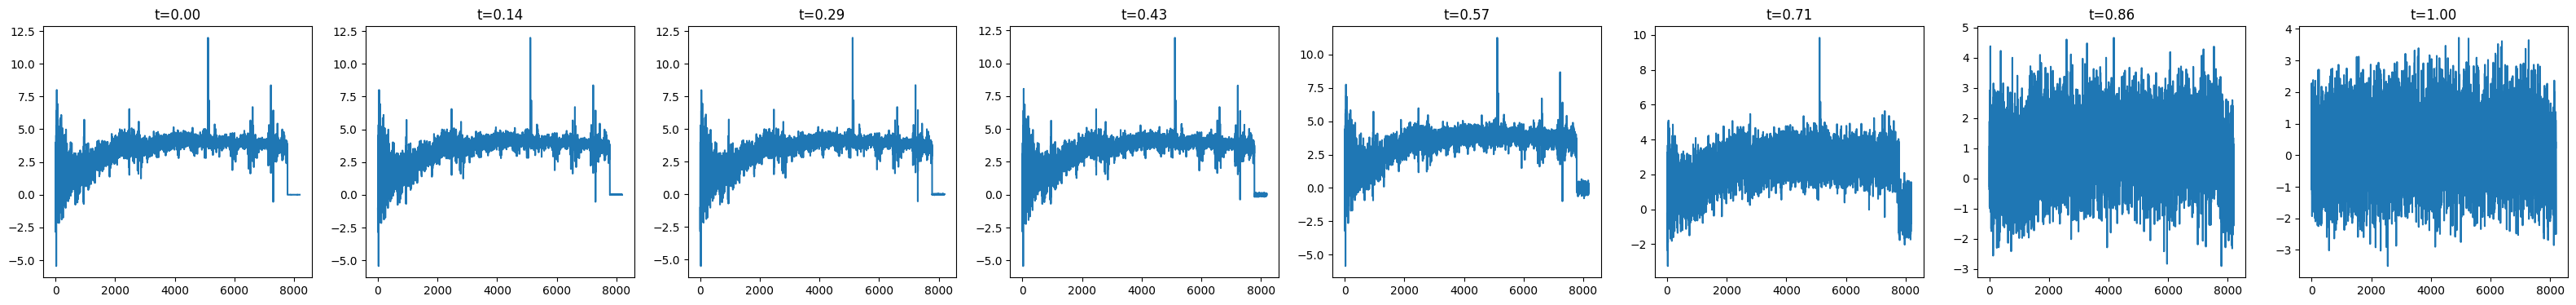

In [21]:

plot_steps = torch.Tensor(np.linspace(0.,1., 8), )
fig, ax = plt.subplots(1,len(plot_steps), figsize=(5 * len(plot_steps),4))
spectra = dataset['train'][0]['spectrum'][:].squeeze()[None,None,:]
spectra = F.pad(spectra, (0, padding_length))
for i, t in enumerate(plot_steps):
    noisy_spectra, _ = spectra_vdm.diffusion.get_xt(spectra, torch.tensor([t]))
    ax[i].plot(noisy_spectra.cpu().detach().squeeze().T)
    ax[i].set_title(f"t={t:.2f}")

In [22]:
# let's create a new logger
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="IAIFI_HACK", log_model="all")



In [23]:

trainer = L.Trainer(
    max_steps = 300_000, gradient_clip_val=0.5, logger=wandb_logger, log_every_n_steps=10, val_check_interval=1_000
)
trainer.fit(model=spectra_vdm, train_dataloaders=train_loader, val_dataloaders = val_loader)



Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/jet/home/cuestala/.local/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type              | Params
------------------------------------------------
0 | diffusion | GaussianDiffusion | 991 K 
------------------------------------------------
991 K     Trainable params
0         Non-tr

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_45806/3208574350.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sp = torch.tensor(sp.swapaxes(1,2), dtype=torch.float32).to(self.device)


Now, can you create a conditional diffusion model that generates spectra given images? and vice-versa?